# Ejemplo de resolución del problema de Poisson una distribución de Dirac #


El problema a resolver es:


\begin{eqnarray*}
-\Delta u &=& f + q\delta(x_0) \;\;\;\;\; \mbox{in } \Omega \\
u &=& h \;\;\;\;\; \mbox{in } \partial \Omega_{ext} \\
\end{eqnarray*}

Para ello impondremos la versión débil del mismo:

Encuentre $u$ en $H^1(\Omega, f))$ (o sea con las condiciones de contorno de Dirichlet en $\partial \Omega_{int}$) tal que,

$$
\int_{\Omega} \nabla v \cdot \nabla u \; d\Omega 
- \int_{\Omega} v \; f \; d\Omega + q*v(x_0)
= 0 \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Si obtenemos un $u$ satisfaciendo esta ecuación, y es suficientemente suave, entonces podemos integrar por partes el primer término y obtener:

$$
\int_{\Omega}  v \; (-\Delta u - f) \; d\Omega 
= q \delta_{x_0}(v) \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Tomando $v$ arbitrario pero de soporte compacto vemos que $u$ debe satisfacer:

$$
-\Delta u = f + q\delta_{x_0}\;\;\;\;\; \mbox{in } \Omega,
$$

La condición de Dirichlet es automática por la elección del espacio.



Para resolver el problema utilizaremos la infraestructura del paquete `Gridap.jl` de Julia. Este ejemplo es una recopilación de varios ejemplos en el tutorial del paquete. 

In [1]:
import Pkg; Pkg.activate("gridap_makie")
using Gridap
using GridapMakie, GLMakie #Para graficar 
using FileIO #Gráficos y salidas
#mkdir("models")
#mkdir("images")
using GridapGmsh
using gmsh

Vamos a usar una grilla especial para el problema, donde hemos elegido el punto donde estará la delta como un nodo de la misma. La manera de construirla está en "models/central_point.geo"

In [2]:
model = GmshDiscreteModel("models/central_point.msh")



Info    : Reading 'models/central_point.msh'...
Info    : 10 entities
Info    : 5130 nodes
Info    : 5210 elements
Info    : Done reading 'models/central_point.msh'


UnstructuredDiscreteModel()

In [3]:
Ω = Triangulation(model)


UnstructuredGrid()

In [35]:
degree = 2
dΩ = Measure(Ω,degree)


Measure()

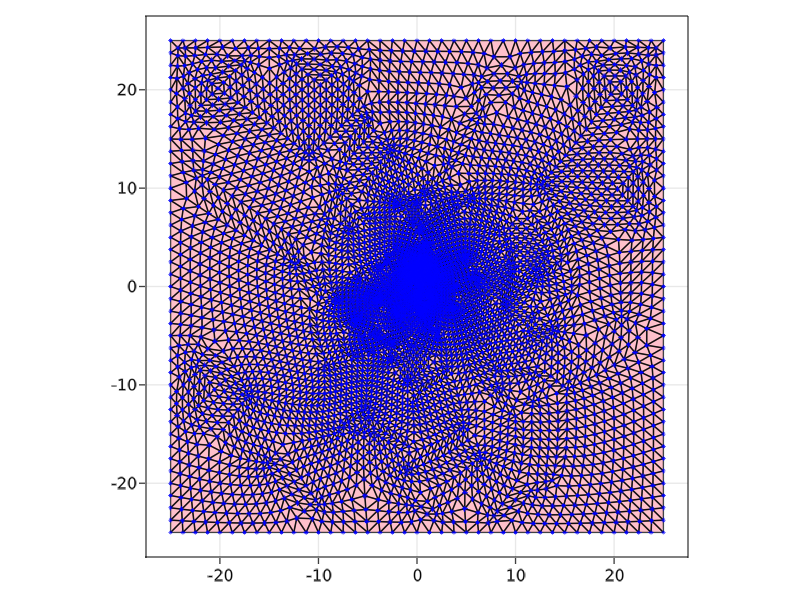

In [36]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1)
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig


Tambén podemos graficar los contornos:

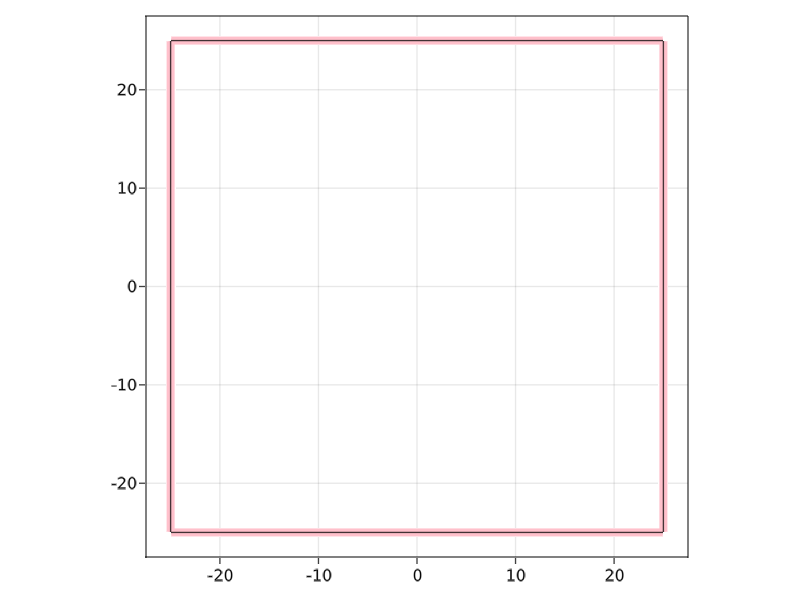

In [37]:
#labels = get_face_labeling(model)
#add_tag_from_tags!(labels,"diri",[8])
#add_tag_from_tags!(labels,"point",[7]);

#boundary_tags = "diri"
boundary_tags = ["boundary"]

Γ = BoundaryTriangulation(model,tags=boundary_tags)
dΓ = Measure(Γ,degree)
fig, ax = plot(Γ, linewidth=8)
ax.aspect = AxisAspect(1)
wireframe!(Γ, color=:black, linewidth=1)
fig


Una vez que tenemos el grillado comenzamos a definir los elementos finitos que utilizaremos. En este caso usaremos elementos lagrangiano de **orden 2** que cumplirán una condición de Dirichlet en la región $\partial \Omega_{boundary}$. 

In [38]:
order = 1
reffe = ReferenceFE(lagrangian,Float64,order)

dirichlet_tags= ["boundary"] 

V = TestFESpace(model,reffe;conformity=:H1,dirichlet_tags = dirichlet_tags)
#V = TestFESpace(model,reffe;conformity=:L2,dirichlet_tags = dirichlet_tags) #no funciona la inversión.


UnconstrainedFESpace()

Asignamos los valores de contorno para los potenciales. 

In [39]:
U = TrialFESpace(V,[0.0])


TrialFESpace()

A continuación definimos el problema débil en forma abstracta:

In [40]:
f(x) = 0 # en este caso la fuente es cero, pero se puede poner una distribución de carga.
#δ_point = DiracDelta{0}(model,tags=["mypoint1","mypoint2"])
δ = DiracDelta{0}(model,tags="point")

q = 1



a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ  # en a(u,v) va toda la dependencia con u que es la incógnita. 

b(v) = ∫(v*f )*dΩ + δ( q⋅v ) # aquí todo lo que es fuente. 


b (generic function with 1 method)

A partir de este punto el paquete **Gridap.jl** genera un sistema del tipo $Ax=b$ y lo resuelve para la versión elementos finitos de u.

In [41]:
op = AffineFEOperator(a,b,U,V)


AffineFEOperator()

In [42]:
ls = LUSolver()
solver = LinearFESolver(ls)


LinearFESolver()

In [43]:
uh = solve(solver,op)


SingleFieldFEFunction():
 num_cells: 5049
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 6784266176296404069

Ahora podemos graficar la solución encontrada y guardarla además en un archivo que se puede leer con paraview o visit.

In [44]:
fig, ax, plt = plot(Ω, uh)
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig


Figure()

In [45]:
writevtk(Ω,"images/delta",cellfields=["ϕ" => uh])
writevtk(Ω,"images/E_delta",cellfields=["E" => -∇(uh)])


(["images/E_delta.vtu"],)